# Learning to Smell with Polyssifier

Problem introduction: https://www.aicrowd.com/challenges/learning-to-smell

Author: Huaping Ding

This notebook will show all experiments on produce the best models with classic ML classifers via Polyssifier. 
The step involves: 
* data loading
* feature engineering: use thousands of molecular descriptors as features
* data spliting
* model building and optimization
* prediction on test set

Requirements:
* Install conda
* Install rdkit, mordred: `conda install -c rdkit -c mordred-descriptor mordred`
* Install polyssifier: `pip install polyssifier`


In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from mordred import Calculator, descriptors
import mordred
from polyssifier import poly
import numpy as np

In [2]:
raw_df = pd.read_csv('./dataset/train.csv')
raw_df['SENTENCE_ARRAY'] = raw_df['SENTENCE'].apply(lambda x: x.split(','))
raw_df.head(9)

,SMILES,SENTENCE,SENTENCE_ARRAY
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose","[fruity, rose]"
1,COC(=O)OC,"fresh,ethereal,fruity","[fresh, ethereal, fruity]"
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic","[resinous, animalic]"
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic","[powdery, musk, animalic]"
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity","[coniferous, camphor, fruity]"
5,CCC[C@H](CCO)SC,tropicalfruit,[tropicalfruit]
6,CC(C)C(=O)OCc1ccco1,"fruity,coffee","[fruity, coffee]"
7,OC[C@H]1[C@H]2CC[C@H]3[C@@]1(C)CCCC([C@@H]23)(C)C,woody,[woody]
8,CCc1ccc(cc1)CC(C=O)(C)C,"clean,fresh","[clean, fresh]"


In [3]:
raw_df['SENTENCE_ARRAY'].apply(lambda x: len(x)).value_counts()

3     1213
2     1143
4      749
1      622
5      363
6      137
7       55
8       26
9        5
10       2
11       1
Name: SENTENCE_ARRAY, dtype: int64

### Define Target Label

In [4]:
vocabulary = pd.read_csv('./dataset/vocabulary.txt', header=None, names=['SMELL'])
vocabulary.head(3)

,SMELL
0,alcoholic
1,aldehydic
2,alliaceous


### Method 1 (deprecated): each smell is encoded as a binary class separately

In [5]:
for idx, row in vocabulary.iterrows():
    class_name = "class_" + str(idx)
    raw_df[class_name] = raw_df['SENTENCE_ARRAY'].apply(lambda x: 1 if row['SMELL'] in x else 0)

raw_df.head()

,SMILES,SENTENCE,SENTENCE_ARRAY,class_0,class_1,class_2,class_3,class_4,class_5,class_6,...,class_99,class_100,class_101,class_102,class_103,class_104,class_105,class_106,class_107,class_108
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose","[fruity, rose]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,COC(=O)OC,"fresh,ethereal,fruity","[fresh, ethereal, fruity]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic","[resinous, animalic]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic","[powdery, musk, animalic]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity","[coniferous, camphor, fruity]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Method 2: use multiple class label maximum to 3 class

In [5]:
drop_classes = list(filter(lambda x: 'class_' in x, list(raw_df.columns)))
raw_df.drop(drop_classes, inplace=True, axis=1)

In [6]:
vocab_dict = {}
for idx, row in vocabulary.iterrows():
    vocab_dict[row['SMELL']] = idx

In [7]:
# raw_df['LEN'] = raw_df['SENTENCE_ARRAY'].apply(lambda x: len(x) )

num_classes = 3
for i in range(num_classes):
    class_name = "topclass_" + str(i)
    raw_df[class_name] = raw_df['SENTENCE_ARRAY'].apply(lambda x: vocab_dict[x[i]] if len(x)>=i+1 else -1 )

raw_df.head()

,SMILES,SENTENCE,SENTENCE_ARRAY,topclass_0,topclass_1,topclass_2
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose","[fruity, rose]",48,89,-1
1,COC(=O)OC,"fresh,ethereal,fruity","[fresh, ethereal, fruity]",47,42,48
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic","[resinous, animalic]",86,8,-1
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic","[powdery, musk, animalic]",83,71,8
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity","[coniferous, camphor, fruity]",34,21,48


#### Feature engineering with molecular descriptors

In [8]:
raw_df['SMILES'][0:10]

0                          C/C=C/C(=O)C1CCC(C=C1C)(C)C
1                                            COC(=O)OC
2                                  Cc1cc2c([nH]1)cccc2
3                               C1CCCCCCCC(=O)CCCCCCC1
4                     CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C
5                                      CCC[C@H](CCO)SC
6                                  CC(C)C(=O)OCc1ccco1
7    OC[C@H]1[C@H]2CC[C@H]3[C@@]1(C)CCCC([C@@H]23)(C)C
8                              CCc1ccc(cc1)CC(C=O)(C)C
9      CC(C)[C@@H]1CC[C@@](C)([C@H]2CCC(=C[C@@H]12)C)O
Name: SMILES, dtype: object

In [9]:
calc = Calculator(descriptors, ignore_3D=True)
print("number of molecular descriptors: ", len(calc.descriptors))
print("Top 10 descriptors: ", calc.descriptors[0:10])

number of molecular descriptors:  1613
Top 10 descriptors:  (mordred.ABCIndex.ABCIndex(), mordred.ABCIndex.ABCGGIndex(), mordred.AcidBase.AcidicGroupCount(), mordred.AcidBase.BasicGroupCount(), mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpMax'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpDiam'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpAD'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpMAD'), mordred.AdjacencyMatrix.AdjacencyMatrix('LogEE'))


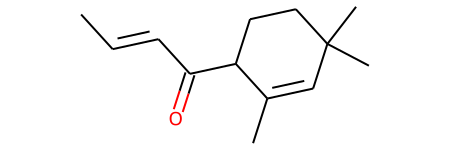

In [10]:
mol = Chem.MolFromSmiles(raw_df.iloc[0]['SMILES'])
mol

#### Option A) Regenerate Modred features

In [16]:
# calculate multiple molecules
raw_mols = [Chem.MolFromSmiles(smi) for smi in raw_df['SMILES']]

mols_desc_df = calc.pandas(raw_mols)
mols_desc_df.head()

100%|██████████| 4316/4316 [02:00<00:00, 35.81it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10.355232,9.695963,0,0,15.9217,2.37344,4.74689,15.9217,1.13727,3.53381,...,9.474165,45.559427,192.151415,5.651512,305,19,68.0,76.0,6.64583,3.138889
1,3.644924,4.097495,0,0,6.89898,1.93185,3.8637,6.89898,1.14983,2.5958,...,7.280008,29.753427,90.031694,7.502641,31,4,20.0,19.0,3.61111,1.666667
2,7.847124,7.174621,0,0,13.043,2.36361,4.55714,13.043,1.3043,3.26103,...,9.085117,53.938362,131.073499,6.898605,108,11,52.0,60.0,2.83333,2.194444
3,12.130205,8.271213,0,0,21.3099,2.06235,4.12469,21.3099,1.25352,3.68802,...,8.551595,46.913417,238.229666,5.068716,592,18,70.0,71.0,4.86111,4.166667
4,13.314894,12.642147,0,0,20.1051,2.63153,4.9989,20.1051,1.18265,3.77866,...,10.159950,67.546910,238.193280,5.539379,505,27,94.0,115.0,7.81944,3.520833


In [17]:
drop_missing_features = []
for col in mols_desc_df.columns:
    bad_count_arr = [1 if type(x) == mordred.error.Missing else 0 for x in mols_desc_df[col]]
    if sum(bad_count_arr) > 0:
        drop_missing_features.append(col)

print("need to drop {} number of descriptors due to missing value".format(len(drop_missing_features)))
mols_desc_df.drop(drop_missing_features, inplace=True, axis=1)
n_features = mols_desc_df.shape[1]
print("Shape of remaining dataframe: {}".format(mols_desc_df.shape))

need to drop 972 number of descriptors due to missing value
Shape of remaining dataframe: (4316, 641)


In [19]:
full_info_df = pd.concat([raw_df, mols_desc_df], axis=1)
full_info_df.head()

,SMILES,SENTENCE,SENTENCE_ARRAY,topclass_0,topclass_1,topclass_2,ABC,ABCGG,nAcid,nBase,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose","[fruity, rose]",48,89,-1,10.355232,9.695963,0,0,...,0.000000,9.474165,45.559427,192.151415,5.651512,305,19,68.0,76.0,3.138889
1,COC(=O)OC,"fresh,ethereal,fruity","[fresh, ethereal, fruity]",47,42,48,3.644924,4.097495,0,0,...,0.000000,7.280008,29.753427,90.031694,7.502641,31,4,20.0,19.0,1.666667
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic","[resinous, animalic]",86,8,-1,7.847124,7.174621,0,0,...,6.803505,9.085117,53.938362,131.073499,6.898605,108,11,52.0,60.0,2.194444
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic","[powdery, musk, animalic]",83,71,8,12.130205,8.271213,0,0,...,0.000000,8.551595,46.913417,238.229666,5.068716,592,18,70.0,71.0,4.166667
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity","[coniferous, camphor, fruity]",34,21,48,13.314894,12.642147,0,0,...,7.984463,10.159950,67.546910,238.193280,5.539379,505,27,94.0,115.0,3.520833


In [20]:
output_file = './dataset/train-data-with-class-and-descriptors-v3.csv'
full_info_df.to_csv(output_file, index=False)

#### Option B) Load existing modred features previously computed

In [17]:
# If the data is newly generated, skip this cell
input_file = './dataset/train-data-with-class-and-descriptors-v3.csv'

try:
    full_info_df.shape
except NameError:
    full_info_df = pd.read_csv(input_file)
    n_features = 641; num_classes = 3
    full_info_df.head()

In [18]:
full_info_df.columns

Index(['SMILES', 'SENTENCE', 'SENTENCE_ARRAY', 'topclass_0', 'topclass_1',
       'topclass_2', 'ABC', 'ABCGG', 'nAcid', 'nBase',
       ...
       'SRW09', 'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1',
       'Zagreb2', 'mZagreb2'],
      dtype='object', length=647)

In [19]:
feature_names = full_info_df.columns[-n_features:]
raw_data_df = full_info_df[feature_names]
raw_data_df = raw_data_df.fillna(value=0) # There are still some missing values for 3 columns
raw_data_df.head()

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,10.355232,9.695963,0,0,0,0,34,14,0,0,...,0.000000,9.474165,45.559427,192.151415,5.651512,305,19,68.0,76.0,3.138889
1,3.644924,4.097495,0,0,0,0,12,6,0,0,...,0.000000,7.280008,29.753427,90.031694,7.502641,31,4,20.0,19.0,1.666667
2,7.847124,7.174621,0,0,9,10,19,10,0,0,...,6.803505,9.085117,53.938362,131.073499,6.898605,108,11,52.0,60.0,2.194444
3,12.130205,8.271213,0,0,0,0,47,17,0,0,...,0.000000,8.551595,46.913417,238.229666,5.068716,592,18,70.0,71.0,4.166667
4,13.314894,12.642147,0,0,0,0,43,17,0,2,...,7.984463,10.159950,67.546910,238.193280,5.539379,505,27,94.0,115.0,3.520833


In [20]:
label_names = full_info_df.columns[3:num_classes+3]
raw_label_df = full_info_df[label_names]
raw_label_df.head()

,topclass_0,topclass_1,topclass_2
0,48,89,-1
1,47,42,48
2,86,8,-1
3,83,71,8
4,34,21,48


### Model Optimization with Polyssifier 

#### 1. Predicting 1st smell of a molecular

In [10]:
data = raw_data_df.values
label = raw_label_df['topclass_0'].values
print("data shape: {}, label shape: {}".format(data.shape, label.shape))

data shape: (4316, 641), label shape: (4316,)


2020-12-02 03:35:30,635 - polyssifier - INFO - Building classifiers ...
2020-12-02 03:35:30,653 - polyssifier - INFO - Initialization, done.
2020-12-02 03:35:35,712 - polyssifier - INFO - Training Multilayer Perceptron 0
2020-12-02 03:35:36,670 - polyssifier - INFO - Training SVM 0
2020-12-02 03:35:36,763 - polyssifier - INFO - Training Nearest Neighbors 1
2020-12-02 03:35:36,784 - polyssifier - INFO - Training Multilayer Perceptron 2
2020-12-02 03:36:40,330 - polyssifier - INFO - Nearest Neighbors          1: Train 0.97/Test 0.21, 63.57 sec
2020-12-02 03:36:47,898 - polyssifier - INFO - Training Nearest Neighbors 2
2020-12-02 03:37:32,346 - polyssifier - INFO - Multilayer Perceptron      0: Train 0.85/Test 0.18, 116.64 sec
2020-12-02 03:37:33,302 - polyssifier - INFO - Multilayer Perceptron      2: Train 0.86/Test 0.20, 116.52 sec
2020-12-02 03:37:36,450 - polyssifier - INFO - Training Multilayer Perceptron 1
2020-12-02 03:37:37,821 - polyssifier - INFO - Training Nearest Neighbors 0


                                 mean       std       min       max
Multilayer Perceptron train  0.851364  0.005463  0.845159  0.855450
                      test   0.191342  0.007135  0.184296  0.198562
Nearest Neighbors     train  0.966250  0.000802  0.965473  0.967075
                      test   0.202481  0.004226  0.198154  0.206598
SVM                   train  0.252679  0.006062  0.248859  0.259669
                      test   0.123779  0.012964  0.115292  0.138701
Linear SVM            train  0.549309  0.099997  0.434209  0.614827
                      test   0.131784  0.012137  0.120776  0.144800
Decision Tree         train  0.859836  0.003611  0.855695  0.862334
                      test   0.165131  0.003712  0.161613  0.169010
Random Forest         train  0.858795  0.003485  0.854772  0.860865
                      test   0.202491  0.007352  0.195804  0.210364
Logistic Regression   train  0.490507  0.012060  0.477522  0.501356
                      test   0.216362  0.006067 

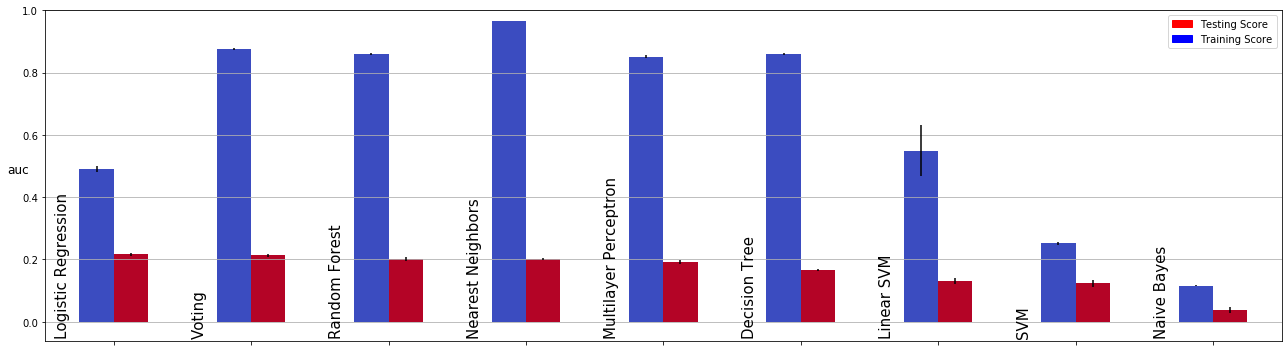

In [11]:
exclude_list = []#'SVM', 'Linear SVM']

report = poly(data, label, n_folds=3, verbose=True, save=True, scale=True,
              feature_selection=False, scoring='jaccard', concurrency=4, exclude=exclude_list)
report.plot_scores()

In [14]:
report.scores

Multilayer Perceptron           Nearest Neighbors                 SVM  \
                  train      test             train      test     train   
0              0.845159  0.184296          0.967075  0.198154  0.259669   
1              0.853481  0.191169          0.966201  0.206598  0.248859   
2               0.85545  0.198562          0.965473   0.20269  0.249511   

            Linear SVM           Decision Tree           Random Forest  \
       test      train      test         train      test         train   
0  0.117344   0.614827    0.1448      0.855695  0.161613      0.854772   
1  0.115292    0.59889  0.120776      0.861477   0.16901      0.860748   
2  0.138701   0.434209  0.129776      0.862334  0.164769      0.860865   

            Logistic Regression           Naive Bayes               Voting  \
       test               train      test       train       test     train   
0  0.195804            0.501356  0.222417    0.119178  0.0304717  0.872580   
1  0.201304            0.492644  0.210282     0.11694  0.0494589  0.879916   
2  0.210364            0.477522  0.216388     0.11275  0.0317503  0.877339   

             
       test  
0  0.206813  
1  0.211786  
2  0.220260

#### 2. Predicting 2nd smell of a molecular

2020-12-02 01:13:40,991 - polyssifier - INFO - Building classifiers ...
2020-12-02 01:13:41,006 - polyssifier - INFO - Initialization, done.


(4316, 641)
(4316,)


2020-12-02 01:13:45,188 - polyssifier - INFO - Training Multilayer Perceptron 0
2020-12-02 01:13:46,179 - polyssifier - INFO - Training Multilayer Perceptron 2
2020-12-02 01:13:46,208 - polyssifier - INFO - Training Nearest Neighbors 1
2020-12-02 01:14:09,450 - polyssifier - INFO - Nearest Neighbors          1: Train 0.96/Test 0.11, 23.24 sec
2020-12-02 01:14:16,791 - polyssifier - INFO - Training Nearest Neighbors 2
2020-12-02 01:14:40,609 - polyssifier - INFO - Nearest Neighbors          2: Train 0.97/Test 0.12, 23.82 sec
2020-12-02 01:14:48,419 - polyssifier - INFO - Training Decision Tree 0
2020-12-02 01:14:52,690 - polyssifier - INFO - Multilayer Perceptron      2: Train 0.08/Test 0.06, 66.51 sec
2020-12-02 01:14:52,887 - polyssifier - INFO - Decision Tree              0: Train 0.84/Test 0.12, 4.47 sec
2020-12-02 01:14:58,870 - polyssifier - INFO - Training Nearest Neighbors 0
2020-12-02 01:14:58,890 - polyssifier - INFO - Training Decision Tree 1
2020-12-02 01:15:03,049 - polyssi

                                 mean       std       min       max
Multilayer Perceptron train  0.130101  0.077145  0.078862  0.218825
                      test   0.073412  0.016671  0.056453  0.089779
Nearest Neighbors     train  0.962372  0.004110  0.958388  0.966598
                      test   0.115402  0.004804  0.111374  0.120719
Decision Tree         train  0.846182  0.002303  0.844031  0.848612
                      test   0.114100  0.002841  0.110825  0.115907
Random Forest         train  0.846865  0.003585  0.843113  0.850254
                      test   0.141134  0.004051  0.137542  0.145525
Logistic Regression   train  0.036370  0.001871  0.034210  0.037477
                      test   0.034934  0.001877  0.032767  0.036072
Naive Bayes           train  0.008314  0.003121  0.005555  0.011701
                      test   0.006151  0.002991  0.003492  0.009389
Voting                train  0.862048  0.009925  0.853880  0.873094
                      test   0.123931  0.005330 

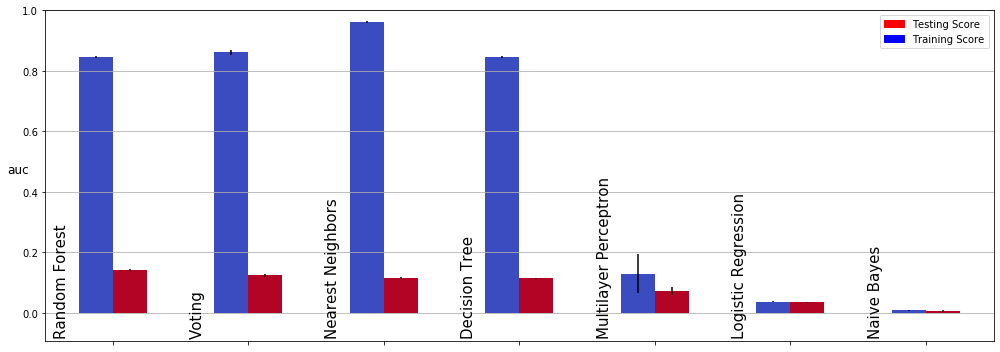

In [13]:
data = raw_data_df.values
label = raw_label_df['topclass_1'].values
print(data.shape)
print(label.shape)

report2 = poly(data, label, n_folds=3, verbose=True, save=False, scale=True,
              feature_selection=False, scoring='jaccard', concurrency=3, exclude=exclude_list)
report2.plot_scores()

#### 3. Predicting 3rd smell of a molecular

2020-12-02 01:20:35,297 - polyssifier - INFO - Building classifiers ...
2020-12-02 01:20:35,311 - polyssifier - INFO - Initialization, done.


(4316, 641)
(4316,)


2020-12-02 01:20:39,832 - polyssifier - INFO - Training Multilayer Perceptron 0
2020-12-02 01:20:40,298 - polyssifier - INFO - Training Nearest Neighbors 1
2020-12-02 01:20:40,470 - polyssifier - INFO - Training Multilayer Perceptron 2
2020-12-02 01:21:10,156 - polyssifier - INFO - Nearest Neighbors          1: Train 0.29/Test 0.25, 29.86 sec
2020-12-02 01:21:17,643 - polyssifier - INFO - Training Nearest Neighbors 2
2020-12-02 01:21:46,942 - polyssifier - INFO - Nearest Neighbors          2: Train 0.36/Test 0.25, 29.30 sec
2020-12-02 01:21:55,137 - polyssifier - INFO - Training Decision Tree 0
2020-12-02 01:22:01,006 - polyssifier - INFO - Decision Tree              0: Train 0.85/Test 0.24, 5.87 sec
2020-12-02 01:22:08,623 - polyssifier - INFO - Training Decision Tree 1
2020-12-02 01:22:14,347 - polyssifier - INFO - Decision Tree              1: Train 0.87/Test 0.22, 5.72 sec
2020-12-02 01:22:17,894 - polyssifier - INFO - Multilayer Perceptron      2: Train 0.26/Test 0.23, 97.42 sec
2

                                 mean       std       min       max
Multilayer Perceptron train  0.288530  0.063434  0.245554  0.361386
                      test   0.234884  0.002437  0.232820  0.237573
Nearest Neighbors     train  0.315942  0.037446  0.292931  0.359151
                      test   0.250957  0.000951  0.250331  0.252052
Decision Tree         train  0.856810  0.007756  0.851932  0.865754
                      test   0.230415  0.014068  0.215008  0.242575
Random Forest         train  0.857547  0.007020  0.852035  0.865450
                      test   0.275375  0.002932  0.272188  0.277959
Logistic Regression   train  0.238331  0.001227  0.236923  0.239176
                      test   0.237824  0.001236  0.236897  0.239228
Naive Bayes           train  0.006446  0.000353  0.006096  0.006803
                      test   0.006093  0.000786  0.005637  0.007000
Voting                train  0.367609  0.055832  0.308716  0.419769
                      test   0.246462  0.005104 

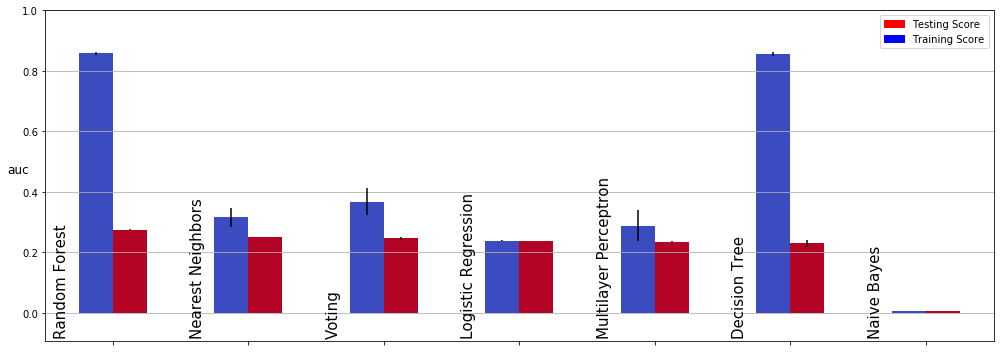

In [14]:
data = raw_data_df.values
label = raw_label_df['topclass_2'].values
print(data.shape)
print(label.shape)

report2 = poly(data, label, n_folds=3, verbose=True, save=False, scale=True,
              feature_selection=False, scoring='jaccard', concurrency=3, exclude=exclude_list)
report2.plot_scores()

#### Summary:
* Most of the algorithms are over-fitting, high performance on training and lower on testing
* Random-forest always produce the best results, let use it to to build 3 models and output prediction on test data. 

## Make Predictions to Test data

### Create the best model with Random Forest on full training data

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Create 3 models for top 3 smells of a molecular

num_classes = 3
data = raw_data_df.values

labels = dict()
clfs = dict()
for i in range(num_classes):
    labels[i] = raw_label_df['topclass_'+str(i)].values

    clfs[i] = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=25, max_features='auto')
    clfs[i].fit(data, labels[i])

#### Preparing test data (Option1: first-time)

In [31]:
# Loading test raw data
test_df = pd.read_csv('./dataset/test.csv')
print("test df shape: {}".format(test_df.shape))

# Loading vocabulary
vocabulary = pd.read_csv('./dataset/vocabulary.txt', header=None, names=['SMELL'])
    
test_df.head()

test df shape: (1079, 1)


,SMILES
0,CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C
1,CC(C)C1CCC(C)CC1OC(=O)CC(C)O
2,CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C
3,CC(=O)OCC(COC(=O)C)OC(=O)C
4,CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C


In [32]:
# Computing the molecular descriptor
calc = Calculator(descriptors, ignore_3D=True)

# calculate multiple molecules
test_mols = [Chem.MolFromSmiles(smi) for smi in test_df['SMILES']]

test_desc_df = calc.pandas(test_mols)
test_desc_df.head()

100%|██████████| 1079/1079 [00:27<00:00, 39.75it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,13.165064,12.751639,0,0,20.8906,2.63224,5.00356,20.8906,1.22886,3.7791,...,10.185541,67.611521,238.193280,5.539379,493,29,94.0,117.0,7.81944,3.631944
1,12.596274,11.583238,0,0,19.3716,2.34326,4.68652,19.3716,1.13951,3.71534,...,9.446598,48.994290,242.188195,5.632284,538,22,80.0,88.0,7.91667,3.805556
2,10.422282,9.772478,0,0,16.3657,2.39962,4.79924,16.3657,1.16898,3.53412,...,9.538132,45.670194,192.151415,5.651512,304,20,68.0,77.0,6.64583,3.083333
3,10.555834,10.234996,0,0,16.6853,2.15765,4.31529,16.6853,1.11235,3.54222,...,8.707648,44.833687,218.079038,7.519967,424,14,62.0,62.0,7.69444,3.500000
4,13.872588,11.883032,0,0,23.2833,2.09695,4.19391,23.2833,1.16416,3.82293,...,8.790117,50.778476,280.240230,5.389235,1164,19,80.0,80.0,8.33333,4.916667


In [33]:
drop_missing_features = []
for col in test_desc_df.columns:
    bad_count_arr = [1 if type(x) == mordred.error.Missing else 0 for x in test_desc_df[col]]
    if sum(bad_count_arr) > 0:
        drop_missing_features.append(col)

print("need to drop {} number of descriptors due to missing value".format(len(drop_missing_features)))
test_desc_df.drop(drop_missing_features, inplace=True, axis=1)

print("Shape of remaining dataframe: {}".format(test_desc_df.shape))

need to drop 830 number of descriptors due to missing value
Shape of remaining dataframe: (1079, 783)


In [ ]:
### Align with training data features
try:
    len(feature_names)
except NameError:
    input_file = './dataset/train-data-with-class-and-descriptors-v3.csv'
    full_info_df = pd.read_csv(input_file)
    print("Reloading training data set with descriptors ...")
    n_features = 641; num_classes = 3
    feature_names = full_info_df.columns[-n_features:]

missing_features = np.setdiff1d(feature_names, test_desc_df.columns)
for feature in missing_features:
    test_desc_df[feature] = 0

test_desc_df_match = test_desc_df[feature_names]
test_desc_df_match = test_desc_df_match.fillna(value=0) # In case still some missing values

print("testing data shape: {}".format(test_desc_df_match.shape))

# Save feature and SMILE together
full_test_df = pd.concat([test_df, test_desc_df_match], axis=1)

output_file = './dataset/test-data-with-descriptors-v3.csv'
full_test_df.to_csv(output_file, index=False)
full_test_df.head()

#### Preparing test data (Option 2: re-load existing data)

In [64]:
intest_file = './dataset/test-data-with-descriptors-v3.csv'
full_test_df = pd.read_csv(intest_file)
full_test_df.head()

,SMILES,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C,13.165064,12.751639,0,0,0,0,43,17,0,...,7.984463,10.185541,67.611521,238.193280,5.539379,493,29,94.0,117.0,3.631944
1,CC(C)C1CCC(C)CC1OC(=O)CC(C)O,12.596274,11.583238,0,0,0,0,43,17,0,...,0.000000,9.446598,48.994290,242.188195,5.632284,538,22,80.0,88.0,3.805556
2,CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C,10.422282,9.772478,0,0,0,0,34,14,0,...,0.000000,9.538132,45.670194,192.151415,5.651512,304,20,68.0,77.0,3.083333
3,CC(=O)OCC(COC(=O)C)OC(=O)C,10.555834,10.234996,0,0,0,0,29,15,0,...,0.000000,8.707648,44.833687,218.079038,7.519967,424,14,62.0,62.0,3.500000
4,CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C,13.872588,11.883032,0,0,0,0,52,20,0,...,0.000000,8.790117,50.778476,280.240230,5.389235,1164,19,80.0,80.0,4.916667


#### Prediction method 1: Only one output per model

In [58]:
# Make predictions

data = full_test_df.loc[:, full_test_df.columns != 'SMILES'].values

raw_predictions = []
for i, clf in clfs.items():
    raw_predictions.extend([clf.predict(data)])

raw_predictions = np.array(raw_predictions).T
raw_predictions.shape

(1079, 3)

In [ ]:
raw_predictions

In [96]:
# Convert predictions into smell vocabulary and output result
vocab_dict2 = {}
for idx, row in vocabulary.iterrows():
    vocab_dict2[idx] = row['SMELL']

predictions = [",".join([vocab_dict2[i] for i in np.unique(row) if i >= 0]) for row in raw_predictions]

# pred_df = pd.DataFrame(data=np.array(predictions), columns=['PREDICTIONS'])
test_df['PREDICTIONS'] = predictions
out_file = './dataset/prediction-test-v1.csv'
test_df.to_csv(out_file, header=True, index=False)
test_df.head()

,SMILES,PREDICTIONS
0,CCC(C)C(=O)OC1CC2CCC1(C)C2(C)C,"camphor,coniferous"
1,CC(C)C1CCC(C)CC1OC(=O)CC(C)O,fruity
2,CC(=O)/C=C/C1=CCC[C@H](C1(C)C)C,"violetflower,woody"
3,CC(=O)OCC(COC(=O)C)OC(=O)C,odorless
4,CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C,"fruity,herbal,rose"


## Make Predictions On Training data with CV

In [185]:
from sklearn.ensemble import RandomForestClassifier

In [186]:
# If the data is newly generated, skip this cell
input_file = './dataset/train-data-with-class-and-descriptors-v3.csv'

try:
    full_info_df.shape
except NameError:
    full_info_df = pd.read_csv(input_file)
    n_features = 641; num_classes = 3
    full_info_df['SENTENCE_ARRAY'] = full_info_df['SENTENCE'].apply(lambda x: x.split(','))
    full_info_df.head()

In [187]:
full_info_df.head()

,SMILES,SENTENCE,SENTENCE_ARRAY,topclass_0,topclass_1,topclass_2,ABC,ABCGG,nAcid,nBase,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose","[fruity, rose]",48,89,-1,10.355232,9.695963,0,0,...,0.000000,9.474165,45.559427,192.151415,5.651512,305,19,68.0,76.0,3.138889
1,COC(=O)OC,"fresh,ethereal,fruity","[fresh, ethereal, fruity]",47,42,48,3.644924,4.097495,0,0,...,0.000000,7.280008,29.753427,90.031694,7.502641,31,4,20.0,19.0,1.666667
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic","[resinous, animalic]",86,8,-1,7.847124,7.174621,0,0,...,6.803505,9.085117,53.938362,131.073499,6.898605,108,11,52.0,60.0,2.194444
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic","[powdery, musk, animalic]",83,71,8,12.130205,8.271213,0,0,...,0.000000,8.551595,46.913417,238.229666,5.068716,592,18,70.0,71.0,4.166667
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity","[coniferous, camphor, fruity]",34,21,48,13.314894,12.642147,0,0,...,7.984463,10.159950,67.546910,238.193280,5.539379,505,27,94.0,115.0,3.520833


In [188]:
feature_names = full_info_df.columns[-n_features:]
full_data_df = full_info_df[feature_names]
full_data_df = full_data_df.fillna(value=0) # There are still some missing values for 3 columns
full_data_df.head()

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,10.355232,9.695963,0,0,0,0,34,14,0,0,...,0.000000,9.474165,45.559427,192.151415,5.651512,305,19,68.0,76.0,3.138889
1,3.644924,4.097495,0,0,0,0,12,6,0,0,...,0.000000,7.280008,29.753427,90.031694,7.502641,31,4,20.0,19.0,1.666667
2,7.847124,7.174621,0,0,9,10,19,10,0,0,...,6.803505,9.085117,53.938362,131.073499,6.898605,108,11,52.0,60.0,2.194444
3,12.130205,8.271213,0,0,0,0,47,17,0,0,...,0.000000,8.551595,46.913417,238.229666,5.068716,592,18,70.0,71.0,4.166667
4,13.314894,12.642147,0,0,0,0,43,17,0,2,...,7.984463,10.159950,67.546910,238.193280,5.539379,505,27,94.0,115.0,3.520833


In [189]:
vocabulary = pd.read_csv('./dataset/vocabulary.txt', header=None, names=['SMELL'])
print(vocabulary.head(3))
vocab_dict = {}
for idx, row in vocabulary.iterrows():
    vocab_dict[row['SMELL']] = idx

        SMELL
0   alcoholic
1   aldehydic
2  alliaceous


In [190]:
max_num_multiple_labels = max(full_info_df['SENTENCE_ARRAY'].apply(lambda x: len(x)))
# Collect all the labels for all the moleculars

full_labels_df = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
for i in range(max_num_multiple_labels):
    class_name = "topclass_" + str(i)
    full_labels_df[class_name] = full_info_df['SENTENCE_ARRAY'].apply(lambda x: 
                                                                      vocab_dict[x[i]] if len(x)>=i+1 else -1 )

full_labels_df.head()

,topclass_0,topclass_1,topclass_2,topclass_3,topclass_4,topclass_5,topclass_6,topclass_7,topclass_8,topclass_9,topclass_10
0,48,89,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,47,42,48,-1,-1,-1,-1,-1,-1,-1,-1
2,86,8,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,83,71,8,-1,-1,-1,-1,-1,-1,-1,-1
4,34,21,48,-1,-1,-1,-1,-1,-1,-1,-1


#### Split training data into train and test, build model, and compute Jaccard Similarity

In [191]:
# define my function for jaccard functions

def my_jaccard_score(ndarr1, ndarr2):
    # need to have same dimensions
    if ndarr1.shape[0] != ndarr2.shape[0]:
        print("Number of samples are not same: {} vs. {}".format(ndarr1.shape, ndarr2.shape))
        return None
    scores = [my_jaccard_score_per_row(arr1, arr2) for arr1, arr2 in zip(ndarr1, ndarr2)]
    return [sum(scores)/len(scores), scores]
    

def my_jaccard_score_per_row(arr1, arr2, exclude=-1):
    if type(arr1) == str and type(arr2) == str:
        set1 = set(arr1.split(","))
        set2 = set(arr2.split(","))
    else: 
        set1 = set(arr1) - set([exclude])
        set2 = set(arr2) - set([exclude])

    num_common = len(set1.intersection(set2))
    return num_common/(len(set1)+len(set2)-num_common)

In [192]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
# >>> kf.get_n_splits(X)

In [199]:
# K-fold cross-validations performance of Jaccard similarity

num_labels_to_learn = 3

top_k_pred_to_select = 1

full_data = full_data_df.values; full_labels = full_labels_df.values

idx_fold = 0
for train_index, test_index in kf.split(full_data):
    X_train, X_test = full_data[train_index], full_data[test_index]
    y_train, y_test = full_labels[train_index], full_labels[test_index]
    
    # Train N models for top N smells of a molecular
    clfs = dict()
    for i in range(num_labels_to_learn):
        labels = y_train[:,i]

        clfs[i] = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=25, max_features='auto')
        clfs[i].fit(X_train, labels)
    
    # Make predictions on X_test, and y_test
    preds = None
    for i, clf in clfs.items():
        probs = clf.predict_proba(X_test)
        cur_pred = [[clf.classes_[i] for i in np.argsort(-prob_j)[0:top_k_pred_to_select]] for prob_j in probs]
        if preds is None:
            preds = np.asarray(cur_pred)
        else:
            preds = np.concatenate((preds, np.asarray(cur_pred)), axis=1)

    # Compute final jaccard score
    final_avg_score, scores = my_jaccard_score(y_test, preds)
    print("Jaccord similarity on {}-fold is: {}".format(idx_fold, final_avg_score)) ; idx_fold += 1

Jaccord similarity on 0-fold is: 0.20633126518543168
Jaccord similarity on 1-fold is: 0.21770954036307433
Jaccord similarity on 2-fold is: 0.22286964998436604
Jaccord similarity on 3-fold is: 0.21413719214993823
Jaccord similarity on 4-fold is: 0.1952325773878496


In [ ]:
# exclude_list = ['Multilayer Perceptron', 'Nearest Neighbors', 'Decision Tree', 'Logistic Regression', 'Naive Bayes',
#                 'Random Forest', 'SVM', 'Linear SVM']
